Projet 5 : Catégorisez automatiquement des questions sur Stack Overflow

Vectorisation

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import Python libraries
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import re
import spacy
import gensim
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

In [75]:
from sklearn import manifold, decomposition
import sklearn.metrics as metrics

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
#import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
os.environ["TF_KERAS"]='1'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
#Import des données
global data
#Import des données
data= pd.read_csv('data_cleaned.csv')

Mounted at /content/gdrive


In [ ]:
data = data.drop(columns=['Title','Body','Tags','Id','document','document_cleaned','Body_cleaned', 'Title_cleaned'])

In [ ]:
data = data.astype(str)

In [ ]:
data.head()

,frequent_tags,frequent_word
0,java multithreading,java arraylist string reading thread reading a...
1,php html,post practice web application php mysql show l...
2,ios objective-c xcode,error view controller error view controller in...
3,javascript html css,google map custom default google map map marke...
4,mysql sql,table query table name phone data input table ...


In [ ]:
data[data['frequent_word'].str.contains(' c ')]

,frequent_tags,frequent_word
33,python list,function zip list item tuples convert list ite...
48,c# .net,path display label method path string example ...
85,sql sql-server database performance,join query c c join perform assumption general...
98,c++ c,use c c++ operator device bit controller integ...
131,c++ c,c c++ standard document question answer standa...
...,...,...
44712,html css,svg drop shadow css drop shadow svg element cs...
44731,java,library jni project work java project jni jni ...
44734,java,tomcat write web application eclipse tomcat wo...
44736,c,mean follow error try compile c application bi...


Transformation des tags en liste de mot

In [ ]:
tags = data['frequent_tags'].apply(lambda x: x.split())
tags

0           [java, multithreading]
1                      [php, html]
2        [ios, objective-c, xcode]
3          [javascript, html, css]
4                     [mysql, sql]
                   ...            
44755                        [php]
44756                         [c#]
44757                       [java]
44758                 [javascript]
44759                  [algorithm]
Name: frequent_tags, Length: 44760, dtype: object

Le MultiLabelBinarizer est une classe qui est souvent utilisée dans le traitement de données en apprentissage automatique, en particulier dans les tâches de classification multi-étiquettes. Cette classe permet de transformer les étiquettes textuelles (ou catégoriques) en vecteurs binaires pour faciliter l'entraînement des modèles de classification.

Pour entraîner un modèle de classification, nous avons besoin de transformer ces étiquettes en vecteurs binaires. Le MultiLabelBinarizer permet de faire cette transformation de manière simple et efficace.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags)

# transform target variable
y = multilabel_binarizer.transform(tags)

In [ ]:
joblib.dump(multilabel_binarizer, open('Variables/multilabel.joblib', 'wb'), compress=True)

Chaque ligne du vecteur représente une image, et chaque colonne représente une étiquette (dans l'ordre alphabétique). Si une étiquette est présente pour une image, la valeur correspondante dans le vecteur est 1, sinon elle est 0.

In [ ]:
a=data['frequent_tags'].tolist()
a = ' '.join(a)
print('Nombre de tags :', len(set(a.split())))

Nombre de tags : 50


In [ ]:
#Sauvegarde
joblib.dump(multilabel_binarizer, open('Model/multilabel.joblib', 'wb'), compress=True)  #Model
joblib.dump(tags, open('Variables/tags.joblib', 'wb'), compress=True) #Features

In [ ]:
# Define X and y
X = data["frequent_word"]
X=list(X)

In [ ]:
#Sauvegarde
joblib.dump(X, open('Variables/X.joblib', 'wb'))
#joblib.dump(X_test, open('Variables/X_test.joblib', 'wb'))
#joblib.dump(y_train, open('Variables/y_train.joblib', 'wb'))
#joblib.dump(y_test, open('Variables/y_test.joblib', 'wb'))

le TD-IDF est une méthode pour mesurer l'importance d'un mot dans un document en comparant sa fréquence dans le document à sa fréquence dans l'ensemble des documents. Les mots qui ont un score élevé sont considérés comme importants pour le document.

- La première partie, "Term Frequency", mesure la fréquence d'apparition d'un mot dans un document.
  Par exemple, si le mot "France" apparaît 10 fois dans un document de 1000 mots, la fréquence du terme sera de $ \frac{n}{N} =\frac{10}{1000} = 0,01$.

- La seconde partie, "Inverse Document Frequency", mesure l'importance d'un mot dans le corpus.
  Cette mesure est calculée en utilisant la formule $log(\frac{N}{n})$, où N est le nombre total de documents et n est le nombre de documents dans lesquels le mot apparaît.

  En multipliant ces deux mesures, on obtient un score TD-IDF pour chaque mot dans chaque document. Les mots qui ont un score élevé sont considérés comme importants pour le document.      


  Par exemple, si dans mon dataset un document contient le mot "C#" 10 fois et que le mot n'apparaît que dans 100 des 50 000 documents de la base de données, alors le score TD-IDF pour le mot "C#" dans ce document sera de $ 0,01 \times log(\frac{50 000}{100}) = 0,027$.

## 1) <ins> Vectorisation TFIDF

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=8)

In [ ]:
joblib.dump(X_train, open('Variables/X_train.joblib', 'wb'), compress=True)
joblib.dump(X_test, open('Variables/X_test.joblib', 'wb'), compress=True)

joblib.dump(y_train, open('Variables/y_train.joblib', 'wb'), compress=True)
joblib.dump(y_test, open('Variables/y_test.joblib', 'wb'), compress=True)

In [67]:
tfidf_vectorizer =  TfidfVectorizer(analyzer="word", min_df=10) # check  le fréquence max des mots afin de choisir la valeur du paramètre min_df

# create TF-IDF features
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)
#X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

In [ ]:
#Sauvegarde
joblib.dump(tfidf_vectorizer, open('Model/tfidf_vectorizer.joblib', 'wb'), compress=True)  # Model
joblib.dump(X, open('Variables/X_tfidf.joblib', 'wb')) #Features

In [ ]:
print("Le jeu d'entrainement comporte {} documents pour {} mots".format(X_tfidf_train.shape[0], X_tfidf_train.shape[1]))
print("Le jeu de Test comporte {} documents pour {} mots".format(X_tfidf_test.shape[0], X_tfidf_test.shape[1]))

Le jeu d'entrainement comporte 33570 documents pour 2573 mots
Le jeu de Test comporte 11190 documents pour 2573 mots


In [ ]:
# Transformation en matrice dense pour visualiser
X_tfidf_train = pd.DataFrame(X_tfidf_train.todense(), columns=feature_names_tfidf)
X_tfidf_test = pd.DataFrame(X_tfidf_test.todense(), columns=feature_names_tfidf)

In [ ]:
X_tfidf_train.head() #vbash

,aaa,ab,abc,ability,abort,abstractautowirecapablebeanfactory,abstractbeanfactory,abstraction,acc,accept,...,yml,youtube,yyyy,zend,zip,zlib,zone,zoom,zsh,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.141818,0.0,0.0,0.0


In [ ]:
joblib.dump(X_tfidf_train, open('Variables/X_tfidf_train.joblib', 'wb'), compress=True)
joblib.dump(X_tfidf_test, open('Variables/X_tfidf_test.joblib', 'wb'), compress=True)

In [ ]:
def display_scree_plot(pca):
    fig=plt.figure(figsize=(8,8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show()

In [ ]:
def pca_transformation(train , test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    n_comp = train.shape[1]
    pca = PCA(n_components=n_comp)
    pca.fit(train)
    display_scree_plot(pca)
    pca = PCA(n_components=0.8, random_state=42)
    pca.fit(train)
    train_pca = pca.transform(train)
    test_pca = pca.transform(test)
    print("\nNous conservons {} composantes principales pour garder 80% d'inertie".format(pca.components_.shape[0]))
    return train_pca, test_pca, pca

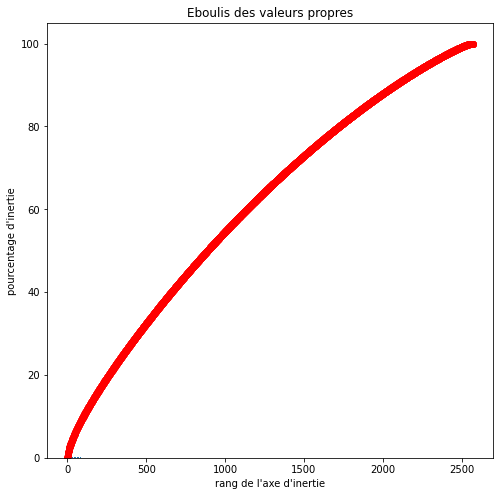


Nous conservons 1724 composantes principales pour garder 80% d'inertie


In [ ]:
X_train_tfidf_pca, X_test_tfidf_pca, pca_tfidf = pca_transformation(X_tfidf_train, X_tfidf_test)

In [ ]:
joblib.dump(X_train_tfidf_pca, open('Variables/X_train_tfidf_pca.joblib', 'wb'), compress=True)
joblib.dump(X_test_tfidf_pca, open('Variables/X_test_tfidf_pca.joblib', 'wb'), compress=True)
joblib.dump(pca_tfidf, open('Model/pca_w2v.joblib', 'wb'), compress=True)

## <ins> Vectorisation Word2Vec

 la fonction simple_preprocess de la bibliothèque Gensim pour prétraiter les données d'entraînement.
  La fonction simple_preprocess prend une chaîne de caractères en entrée et retourne une liste de tokens (mots) prétraités.

In [ ]:
w2v_size=200
w2v_window=8
w2v_min_count=1
w2v_epochs=100
maxlen = 30 # adapt to length of sentences

sentences_train = [gensim.utils.simple_preprocess(text) for text in X_train] # --> Tokénization
sentences_test = [gensim.utils.simple_preprocess(text) for text in X_test]

La fonction Word2Vec crée une nouvelle instance de modèle Word2Vec avec des hyperparamètres spécifiés tels que :
- min_count (nombre minimum d'occurrences d'un mot pour être inclus dans le vocabulaire),

- window (taille de la fenêtre de contexte pour laquelle les co-occurrences de mots sont comptées),

  - Cela signifie que pour chaque mot dans chaque phrase d'entraînement, le modèle considérera les deux mots

  - précédents et les deux mots suivants comme faisant partie de son contexte.
  
  - Par exemple, pour la phrase 'le chat est sur le tapis', le modèle considérera que 'chat' est en relation avec 'le', 'est', 'sur', et 'le'.

- vector_size (nombre de dimensions pour représenter les vecteurs de mots),
- seed (numéro de graine aléatoire pour la reproductibilité des résultats) et workers (nombre de threads pour l'entraînement parallèle).
- workers (nombre de threads pour l'entraînement parallèle).

La méthode build_vocab construit le vocabulaire du modèle à partir de sentences_train, qui contient une liste de tokens prétraités pour chaque document.

In [ ]:
%%time
#Maintenant, nous pouvons entraîner le modèle Word2Vec en utilisant ces phrases
#Chaque mot du vocabulaire est associé à un vecteur de taille w2v_size
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=multiprocessing.cpu_count() - 1)
w2v_model.build_vocab(sentences_train) # construis le vocabulaire du corpus
w2v_model.train(sentences_train, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words)) # vocabulaire du corpus
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2568
Word2Vec trained
Wall time: 54.4 s


Il n'y a pas de valeur "idéale" pour le paramètre vector_size, car cela dépendra de la taille et de la complexité du corpus d'entraînement, ainsi que de la nature spécifique du problème de traitement du langage naturel à résoudre.

En général, un vector_size plus grand peut aider à capturer des informations sémantiques plus riches sur les mots, tandis qu'un vector_size plus petit peut être plus efficace pour les tâches de classification de texte ou de recherche d'informations.

Cependant, il est important de noter que des valeurs de vector_size très élevées peuvent également entraîner des temps d'entraînement plus longs et une consommation de mémoire plus importante. Il est courant de voir des valeurs de vector_size dans la plage de 50 à 300 dans la pratique, mais cela dépendra du corpus d'entraînement et des besoins spécifiques de l'application.

Pendant l'entraînement, le modèle Word2Vec apprend à représenter chaque mot du vocabulaire sous forme d'un vecteur dense dans un espace vectoriel de grande dimension. L'objectif est d'apprendre des représentations vectorielles qui capturent les relations sémantiques et syntaxiques entre les mots dans le corpus, de sorte que les mots similaires soient représentés par des vecteurs similaires et que les mots différents soient représentés par des vecteurs différents. Les vecteurs appris peuvent ensuite être utilisés pour diverses tâches de traitement automatique du langage naturel (TALN), telles que la classification de texte, la recherche d'informations et la génération de langage.

Pendant l'entraînement, le modèle Word2Vec apprend à représenter chaque mot du vocabulaire sous forme d'un vecteur dense dans un espace vectoriel de grande dimension. L'objectif est d'apprendre des représentations vectorielles qui capturent les relations sémantiques et syntaxiques entre les mots dans le corpus, de sorte que les mots similaires soient représentés par des vecteurs similaires et que les mots différents soient représentés par des vecteurs différents. Les vecteurs appris peuvent ensuite être utilisés pour diverses tâches de traitement automatique du langage naturel (TALN), telles que la classification de texte, la recherche d'informations et la génération de langage.

In [ ]:
%%time
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
# Train set
train_token = Tokenizer()
train_token.fit_on_texts(sentences_train)
train_sentences = pad_sequences(train_token.texts_to_sequences(sentences_train),
                                maxlen=maxlen,
                                padding='post') #Chaque est associé à un index
word_index_train = train_token.word_index
# Test set
test_token = Tokenizer()
test_token.fit_on_texts(sentences_test)
test_sentences = pad_sequences(test_token.texts_to_sequences(sentences_test),
                               maxlen=maxlen,
                               padding='post')
word_index_test = test_token.word_index
print("Number of unique words: %i in training set" % len(word_index_train))
print("Number of unique words: %i in testing set" % len(word_index_test))

Fit Tokenizer ...
Number of unique words: 2568 in training set
Number of unique words: 2560 in testing set
Wall time: 1.57 s


## Création de la matrice d'embedding

Chaque ligne de la matrice correspond à un mot spécifique du vocabulaire.Chaque ligne de la matrice correspond à un mot spécifique du vocabulaire. Par exemple, la première ligne peut représenter le mot "le", la deuxième ligne peut représenter le mot "chat", la troisième ligne peut représenter le mot "mange", etc. Les valeurs numériques dans chaque ligne sont les composantes du vecteur d'embedding pour ce mot dans l'espace vectoriel.

La matrice d'embedding est utilisée pour initialiser les embeddings dans un modèle d'apprentissage automatique ou de traitement du langage naturel. Les vecteurs d'embedding captent les informations sémantiques des mots, ce qui permet au modèle de comprendre les relations et les similarités entre les mots lors de l'apprentissage et de la prédiction.

In [ ]:
%%time
# Création de la matrice d'embedding
#Les mots sont en lignes --> vecteurs de mots horizontaux
print("Create Embedding matrix ...")
w2v_size = 200
vocab_size_train = len(word_index_train) + 1
vocab_size_test = len(word_index_test) + 1
embedding_matrix_train = np.zeros((vocab_size_train, w2v_size))
embedding_matrix_test = np.zeros((vocab_size_test, w2v_size))
i=0
j=0

for word, idx in word_index_train.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_train[idx] = model_vectors[word]
i, j = 0, 0
for word, idx in word_index_test.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_test[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix for Train : %s" % str(embedding_matrix_train.shape))
print("Embedding matrix for Test : %s" % str(embedding_matrix_test.shape))

Create Embedding matrix ...
Word embedding rate :  0.9996
Embedding matrix for Train : (2569, 200)
Embedding matrix for Test : (2561, 200)
Wall time: 89.9 ms


In [ ]:
embedding_matrix_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03161621,  0.33854231,  0.03458598, ...,  0.36961034,
         0.05434174, -0.69212675],
       [-3.21058965, -1.89558613, -0.73556072, ..., -0.42973766,
        -1.61756539,  2.58863688],
       ...,
       [-0.66539162, -1.72319746,  0.60283941, ..., -0.53625143,
        -0.66476482,  0.38467601],
       [-0.59090102,  0.22036453,  0.04028786, ...,  0.54952669,
         0.05418508,  1.33731091],
       [-0.16245806, -0.65620631, -0.2952058 , ...,  0.78346914,
         0.13617404, -1.68419302]])

## Création du modèle d'embedding

Nous définissons ensuite la longueur maximale de nos phrases maxlen.

Nous créons ensuite deux objets Input avec les formes appropriées pour représenter les phrases et les mots individuels. Nous utilisons la couche Embedding de Keras pour créer la couche d'embedding, en utilisant la matrice d'embedding aléatoire que nous avons créée précédemment. Enfin, nous utilisons la couche GlobalAveragePooling1D pour calculer la moyenne de chaque vecteur d'embedding dans chaque phrase.

Enfin, nous créons le modèle en utilisant la fonction Model de Keras, en utilisant les objets Input pour définir l'entrée et la sortie du modèle. Le modèle prendra en entrée des phrases représentées par des vecteurs de longueur maxlen, et renverra des vecteurs d'embedding uniques pour chaque phrase.

https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

En résumé, ce code définit un modèle qui prend en entrée des séquences d'entiers représentant des phrases, utilise une couche d'embedding pour obtenir des vecteurs d'embedding pour chaque mot, agrège ces embeddings en utilisant la moyenne, et génère des représentations vectorielles des phrases. Ce modèle peut être utilisé pour l'apprentissage automatique sur des données textuelles, telles que la classification ou la préd

In [ ]:
%%time
# Création du modèle train

input=Input(shape=(len(train_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size_train,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_train],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model_train = Model([word_input],word_vec)

embed_model_train.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           513800    
                                                                 
 global_average_pooling1d (  (None, 200)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 513800 (1.96 MB)
Trainable params: 513800 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Wall time: 225 ms


In [ ]:
# Création du modèle test

input = Input(shape=(len(test_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size_test,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_test],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model_test = Model([word_input],word_vec)

embed_model_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 200)           512200    
                                                                 
 global_average_pooling1d_1  (None, 200)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 512200 (1.95 MB)
Trainable params: 512200 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Exécution du modèle

In [ ]:
%%time
X_w2v_train = embed_model_train.predict(train_sentences)
X_w2v_train.shape

1050/1050 [==============================] - 1s 652us/step
Wall time: 1.19 s


(33570, 200)

In [ ]:
X_w2v_test = embed_model_test.predict(test_sentences)
X_w2v_test.shape

350/350 [==============================] - 0s 641us/step


(11190, 200)

In [ ]:
X_w2v_train

array([[-0.33999655, -0.02531037,  0.18708019, ..., -0.0182542 ,
        -0.07717775, -0.12322999],
       [-0.18202654,  0.07519715,  0.11719489, ...,  0.356726  ,
         0.69023067, -0.7451206 ],
       [-0.20176157, -0.17823258,  0.7574425 , ...,  0.5383589 ,
        -0.6517051 , -0.5620092 ],
       ...,
       [ 0.2866898 ,  0.19482875,  0.53199524, ...,  0.02791971,
         0.35529906,  0.12795159],
       [ 0.6163716 ,  0.6611231 ,  0.4621721 , ..., -0.21569654,
        -0.37785634, -1.1225324 ],
       [-0.03645888,  0.26537588,  0.5257498 , ..., -0.46917948,
         0.16649292, -0.6686849 ]], dtype=float32)

In [ ]:
#Sauvegarde
joblib.dump(w2v_model, open('Model/embed_model_train.joblib', 'wb'), compress=True)
joblib.dump(X_w2v_train, open('Variables/X_w2v_train.joblib', 'wb'))
joblib.dump(X_w2v_test, open('Variables/X_w2v_test.joblib', 'wb'))

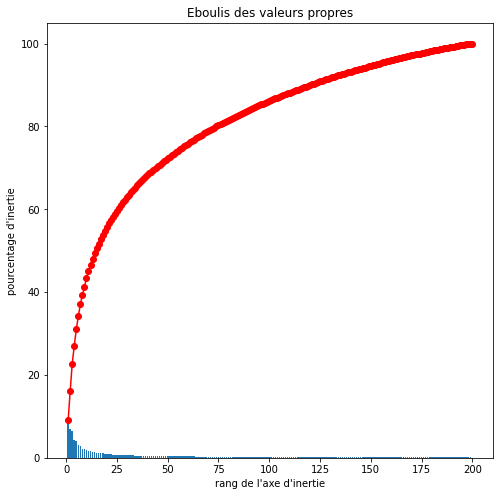


Nous conservons 75 composantes principales pour garder 80% d'inertie


In [ ]:
X_train_w2v_pca, X_test_w2v_pca, pca_w2v = pca_transformation(X_w2v_train, X_w2v_test)

In [ ]:
joblib.dump(X_train_w2v_pca, open('Variables/X_train_w2v_pca.joblib', 'wb'), compress=True)
joblib.dump(X_test_w2v_pca, open('Variables/X_test_w2v_pca.joblib', 'wb'), compress=True)
joblib.dump(pca_w2v, open('Model/pca_w2v.joblib', 'wb'), compress=True)

LDA à faire que pour le TDF-IDF

## 2) <ins> Vectorisation de BERT

In [ ]:
import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
import tensorflow_hub as hub
import tensorflow as tf
import time

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

#### 'bert-base-uncased'

In [ ]:
%%time
max_length = 32
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_train = X_train
sentences_test = X_test


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Wall time: 5.76 s


-- Temps long --> Entrainer sur une partie des données (25 ou 50%)

In [ ]:
%%time  #37 min
# création des features
X_bert_train, last_hidden_hf_train = feature_BERT_fct(model, model_type,
                                                   X_train, max_length,
                                                   batch_size, mode='HF')
#Sauvegarde
joblib.dump(X_bert_train, open('Variables/X_bert_train.joblib', 'wb'), compress=True)
#joblib.dump(X_bert_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_bert_train3.joblib', 'wb'))

In [ ]:
X_bert_train.shape

In [ ]:
%%time
# création des features
X_bert_test, last_hidden_hf_test = feature_BERT_fct(model, model_type,
                                                   X_test, max_length,
                                                   batch_size, mode='HF')
joblib.dump(X_bert_test, open('Variables/X_bert_test.joblib', 'wb'), compress=True)
#joblib.dump(X_bert_test3, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/VariablesX_bert_test3.joblib', 'wb'))

1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 261ms/step
temps traitement :  493.0
Wall time: 8min 14s


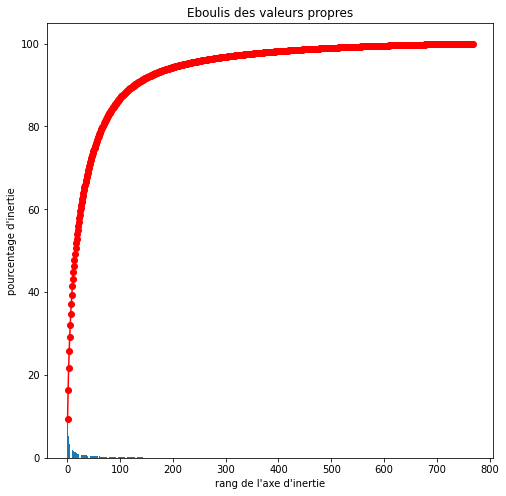


Nous conservons 68 composantes principales pour garder 80% d'inertie


In [ ]:
X_train_bert_pca, X_test_bert_pca, pca_bert = pca_transformation(X_bert_test, X_bert_test)

In [ ]:
joblib.dump(X_train_bert_pca, open('Variables/X_train_bert_pca.joblib', 'wb'), compress=True)
joblib.dump(X_test_bert_pca, open('Variables/X_test_bert_pca.joblib', 'wb'), compress=True)
joblib.dump(pca_bert, open('Model/pca_bert.joblib', 'wb'), compress=True)

# 3) <ins> Vectorisation de USE (Universal Sentence Encoder)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_cache"  # Set a temporary cache directory

# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")



In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
%%time
batch_size = 10
X_use_train= feature_USE_fct(X_train, batch_size)
X_use_test = feature_USE_fct(X_test, batch_size)
joblib.dump(X_use_train, open('Variables/X_use_train.joblib', 'wb'), compress=True)
joblib.dump(X_use_test, open('Variables/X_use_test.joblib', 'wb'), compress=True)

Wall time: 1min 8s


In [ ]:
X_use_train.shape

(33570, 512)

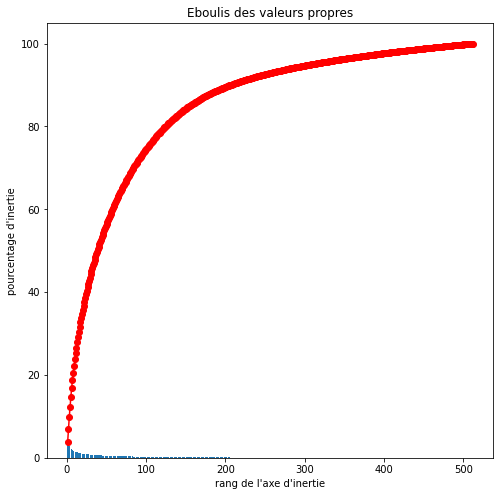


Nous conservons 125 composantes principales pour garder 80% d'inertie


In [ ]:
X_train_use_pca, X_test_use_pca, pca_use = pca_transformation(X_use_train, X_use_test)

In [ ]:
joblib.dump(X_train_use_pca, open('Variables/X_train_use_pca.joblib', 'wb'), compress=True)
joblib.dump(X_test_use_pca, open('Variables/X_test_bert_pca.joblib', 'wb'), compress=True)
joblib.dump(pca_use, open('Model/pca_use.joblib', 'wb'), compress=True)

#  Modélisation

## LDA

In [ ]:
#pip install pyLDAvis

In [70]:
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

In [76]:
# Tokénisation
split_corp = [corp.split() for corp in data['frequent_word']]
# Create a corpus from a list of texts
common_dictionary = corpora.Dictionary(split_corp)
common_dictionary.filter_extremes(no_below=1000)
common_corpus = [common_dictionary.doc2bow(text) for text in split_corp]
Mots = "\n".join("{0} {1}".format(k, v)  for k,v in common_dictionary.items())
tfidf = TfidfModel(common_corpus)
tfidf_corpus = [tfidf[text] for text in common_corpus]

In [ ]:
%%time
# Finding the best number of topic
number_list = [i for i in range(2, 50)]
# Calculate coherence test
coherence_test = []
for k in number_list:
    print("K = {}".format(k))
    model_lda = LdaMulticore(corpus=common_corpus,
                             id2word=common_dictionary,
                             num_topics=k,
                             passes=10,
                             random_state=42,
                             workers=7)
    coherence_model_lda = CoherenceModel(model=model_lda,
                                         texts=split_corp,
                                         dictionary=common_dictionary,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append((k, coherence_lda))

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26
K = 27
K = 28
K = 29
K = 30
K = 31
K = 32
K = 33
K = 34
K = 35
K = 36
K = 37
K = 38
K = 39
K = 40
K = 41
K = 42
K = 43
K = 44
K = 45
K = 46
K = 47
K = 48
K = 49
Wall time: 28min 45s


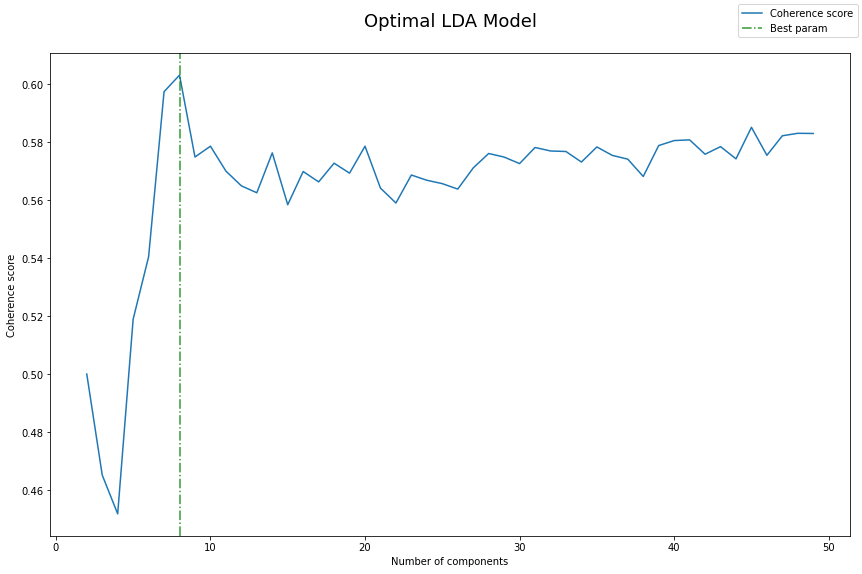

In [ ]:

# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence"])

# Select best number of topics
best_nb_topics = coherence_test\
.loc[coherence_test.coherence.argmax(),"k"]

#Plot results
fig, ax = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y = coherence_test["coherence"]

ax.plot(x, y, label="Coherence score")
ax.axvline(x=best_nb_topics, color='g', alpha=.8,
           linestyle='dashdot', label='Best param')
ax.set_xlabel("Number of components")
ax.set_ylabel("Coherence score")
# Title
plt.title("Optimal LDA Model\n", fontsize=18)
legend = fig.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Best LDA visualization
# Construire le modèle LDA
best_nb_topics =8
best_lda_model = LdaMulticore(corpus=common_corpus,
                              id2word=common_dictionary,
                              num_topics=best_nb_topics,
                              per_word_topics=True,
                              passes=10,
                              workers=7)

In [ ]:
joblib.dump(common_corpus, open("Variables/common_corpus.joblib", 'wb'), compress=True)
joblib.dump(common_dictionary, open("Variables/common_dictionary.joblib", 'wb'), compress=True)
joblib.dump(best_lda_model, open("Model/LDA_model.joblib", 'wb'), compress=True)

Visualisation des résultats de LDA Gensim

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
pyLDAvis.enable_notebook()
%matplotlib inline


gensimvis.prepare(best_lda_model, tfidf_corpus, common_dictionary)

#pyLDAvis.gensim_models.prepare(best_lda_model, tfidf_corpus, common_dictionary)


#gensimvis.prepare(best_lda_model, corpus, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.048630  0.104927       1        1  18.390813
7      0.178971 -0.066924       2        1  15.683231
6     -0.064240 -0.182586       3        1  14.237325
0      0.054656 -0.065095       4        1  12.768772
5      0.077816 -0.072107       5        1  12.221771
2      0.072530  0.079398       6        1   9.825772
1     -0.063957  0.250211       7        1   9.179878
4     -0.304407 -0.047825       8        1   7.692437, topic_info=        Term         Freq        Total Category  logprob  loglift
213  android  1641.000000  1641.000000  Default  30.0000  30.0000
4       java  1667.000000  1667.000000  Default  29.0000  29.0000
77      file  2593.000000  2593.000000  Default  28.0000  28.0000
64     class  2213.000000  2213.000000  Default  27.0000  27.0000
110      app  1234.000000  1234.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
75       com    79.702342   631.001142   Topic8  -4.8285   0.4959
235   import    71.274307   618.239303   Topic8  -4.9403   0.4046
1     change    69.699718   678.169961   Topic8  -4.9626   0.2897
87      work    72.121292  1599.279727   Topic8  -4.9284  -0.5340
31       use    71.846137  2868.383561   Topic8  -4.9323  -1.1220

[349 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
88        1  0.122716  access
88        2  0.096248  access
88        3  0.021656  access
88        4  0.149184  access
88        5  0.375365  access
...     ...       ...     ...
202       4  0.030789     xml
202       5  0.061579     xml
202       6  0.053881     xml
202       7  0.377170     xml
202       8  0.389999     xml

[1501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 7, 1, 6, 3, 2, 5])

Afin d'assigner des tags à chaque question dans ces modèles non supervisés, nous allons construire une matrice Topic/Tags en effectuant une multiplication matricielle des matrices Document/Topic et Document/Tags.


In [ ]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(common_corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (44760, 48)
document/topic :  (44760, 8)


In [ ]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7
0,0.004635,0.309022,0.004635,0.004636,0.626176,0.041619,0.004640,0.004637
1,0.414483,0.002665,0.286324,0.167119,0.002666,0.002666,0.121415,0.002661
2,0.005447,0.692603,0.005449,0.005443,0.005442,0.005439,0.274729,0.005449


A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

In [ ]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y)
topic_tag.shape

(8, 50)


In [ ]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,395.474217,267.503593,736.481577,619.893583,77.738561,48.428451,55.312892,350.976553,835.127956,523.910436,...,100.184911,60.913641,588.167129,86.660074,25.091140,20.455962,32.141621,34.790680,40.346882,34.194429
1,749.991311,40.580393,337.130958,40.259094,450.690831,165.134962,161.141101,182.590511,1135.212663,347.610130,...,88.656266,105.506680,59.693725,54.661696,64.803772,398.296300,416.472534,86.686984,80.642462,155.850426
2,358.251955,42.897297,358.237679,45.405646,180.643297,77.887697,53.982084,165.836031,620.316798,228.008527,...,406.302845,355.126943,59.173252,89.114300,50.836978,47.316972,145.973163,30.100145,29.558071,186.225123
3,331.928379,78.875037,148.884134,131.707712,207.290940,129.144544,72.515985,73.691864,718.950086,108.130064,...,814.085910,477.437537,176.176523,90.822067,33.665201,30.291575,35.231329,78.805889,53.094345,38.507745
4,1201.194204,527.736718,234.943494,222.365377,167.063110,82.855654,65.612056,872.382259,2257.839436,1842.221771,...,209.280646,121.950876,263.599472,95.112988,210.553573,113.355417,148.733681,87.845487,113.174621,89.863643
5,148.210718,50.572056,185.496133,36.644357,34.715147,16.470680,222.932559,183.798072,246.684857,288.323351,...,53.029794,37.478007,79.440345,59.650459,153.204046,76.934001,220.063232,11.983591,20.183679,138.659415
6,89.287632,17.357311,308.037035,22.489337,24.968169,12.814976,10.265180,36.570643,162.523941,79.073613,...,29.964795,16.563862,33.388281,15.724882,37.860453,15.231813,28.996689,6.864050,10.185329,24.613920
7,298.661585,56.477595,509.788992,31.234894,225.889945,98.263036,34.238145,66.154068,547.344268,120.722111,...,40.494832,28.022453,43.361274,247.253532,22.984835,46.117961,83.387751,154.923174,157.814611,219.085298


Donc, nous générons une matrice où les lignes représentent les Topics créés et les colonnes représentent les Tags associés et leurs distributions. Ainsi, pour chaque document, nous allons créer nos prédictions en utilisant les n premiers tags associés aux topics

In [ ]:
tt =pd.DataFrame(tags)
tt

,frequent_tags
0,"[java, multithreading]"
1,"[php, html]"
2,"[ios, objective-c, xcode]"
3,"[javascript, html, css]"
4,"[mysql, sql]"
...,...
44755,[php]
44756,[c#]
44757,[java]
44758,[javascript]


In [ ]:
y_results = pd.DataFrame(tags)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["frequent_tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,frequent_tags,best_topic,nb_tags,y_true
0,"[java, multithreading]",4,2,"[20, 27]"
1,"[php, html]",0,2,"[16, 33]"
2,"[ios, objective-c, xcode]",1,3,"[18, 30, 47]"


In [ ]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)

y_results["y_pred"] = list_tag
y_results.head(3)

,frequent_tags,best_topic,nb_tags,y_true,y_pred
0,"[java, multithreading]",4,2,"[20, 27]","[8, 20]"
1,"[php, html]",0,2,"[16, 33]","[21, 16]"
2,"[ios, objective-c, xcode]",1,3,"[18, 30, 47]","[8, 18, 20]"


Nous allons évaluer plusieurs métriques sur ce modèle LDA :

- Taux de précision (Accuracy score)
- Score F1 (F1 score)
- Coefficient de similarité de Jaccard (Jaccard similarity score)
- Rappel (Recall)
- Précision (Precision)

In [ ]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested.

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame
        DataFrame to extend.
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])

    scores = []
    scores.append(metrics.accuracy_score(y_true,
                                         y_pred))
    scores.append(metrics.f1_score(y_pred,
                                   y_true,
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true,
                                        y_pred,
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true,
                                       y_pred,
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true,
                                          y_pred,
                                          average='weighted'))
    temp_df[model] = scores

    return temp_df

In [ ]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1

lda_y_true = np.zeros(y.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [ ]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

,LDA
Accuracy,0.109763
F1,0.308183
Jaccard,0.105163
Recall,0.241531
Precision,0.205617


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_LDA.joblib", 'wb'), compress=True)

## Modèle NMF

Nous allons donc nous baser sur les résultats de la LDA pour déterminer un nombre correct de composants. Ici, nous prendrons 12 topics pour avoir un bon compromis "temps d'entrainement" / précision et utiliserons les matrices Tfidf créées lors du preprocessing.

In [65]:
def plot_top_words(model, feature_names,
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6,
                             figsize=(30, rows*10),
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on Full_doc ...
--------------------------------------------------
End of training :
Execution time : 2.65s
--------------------------------------------------


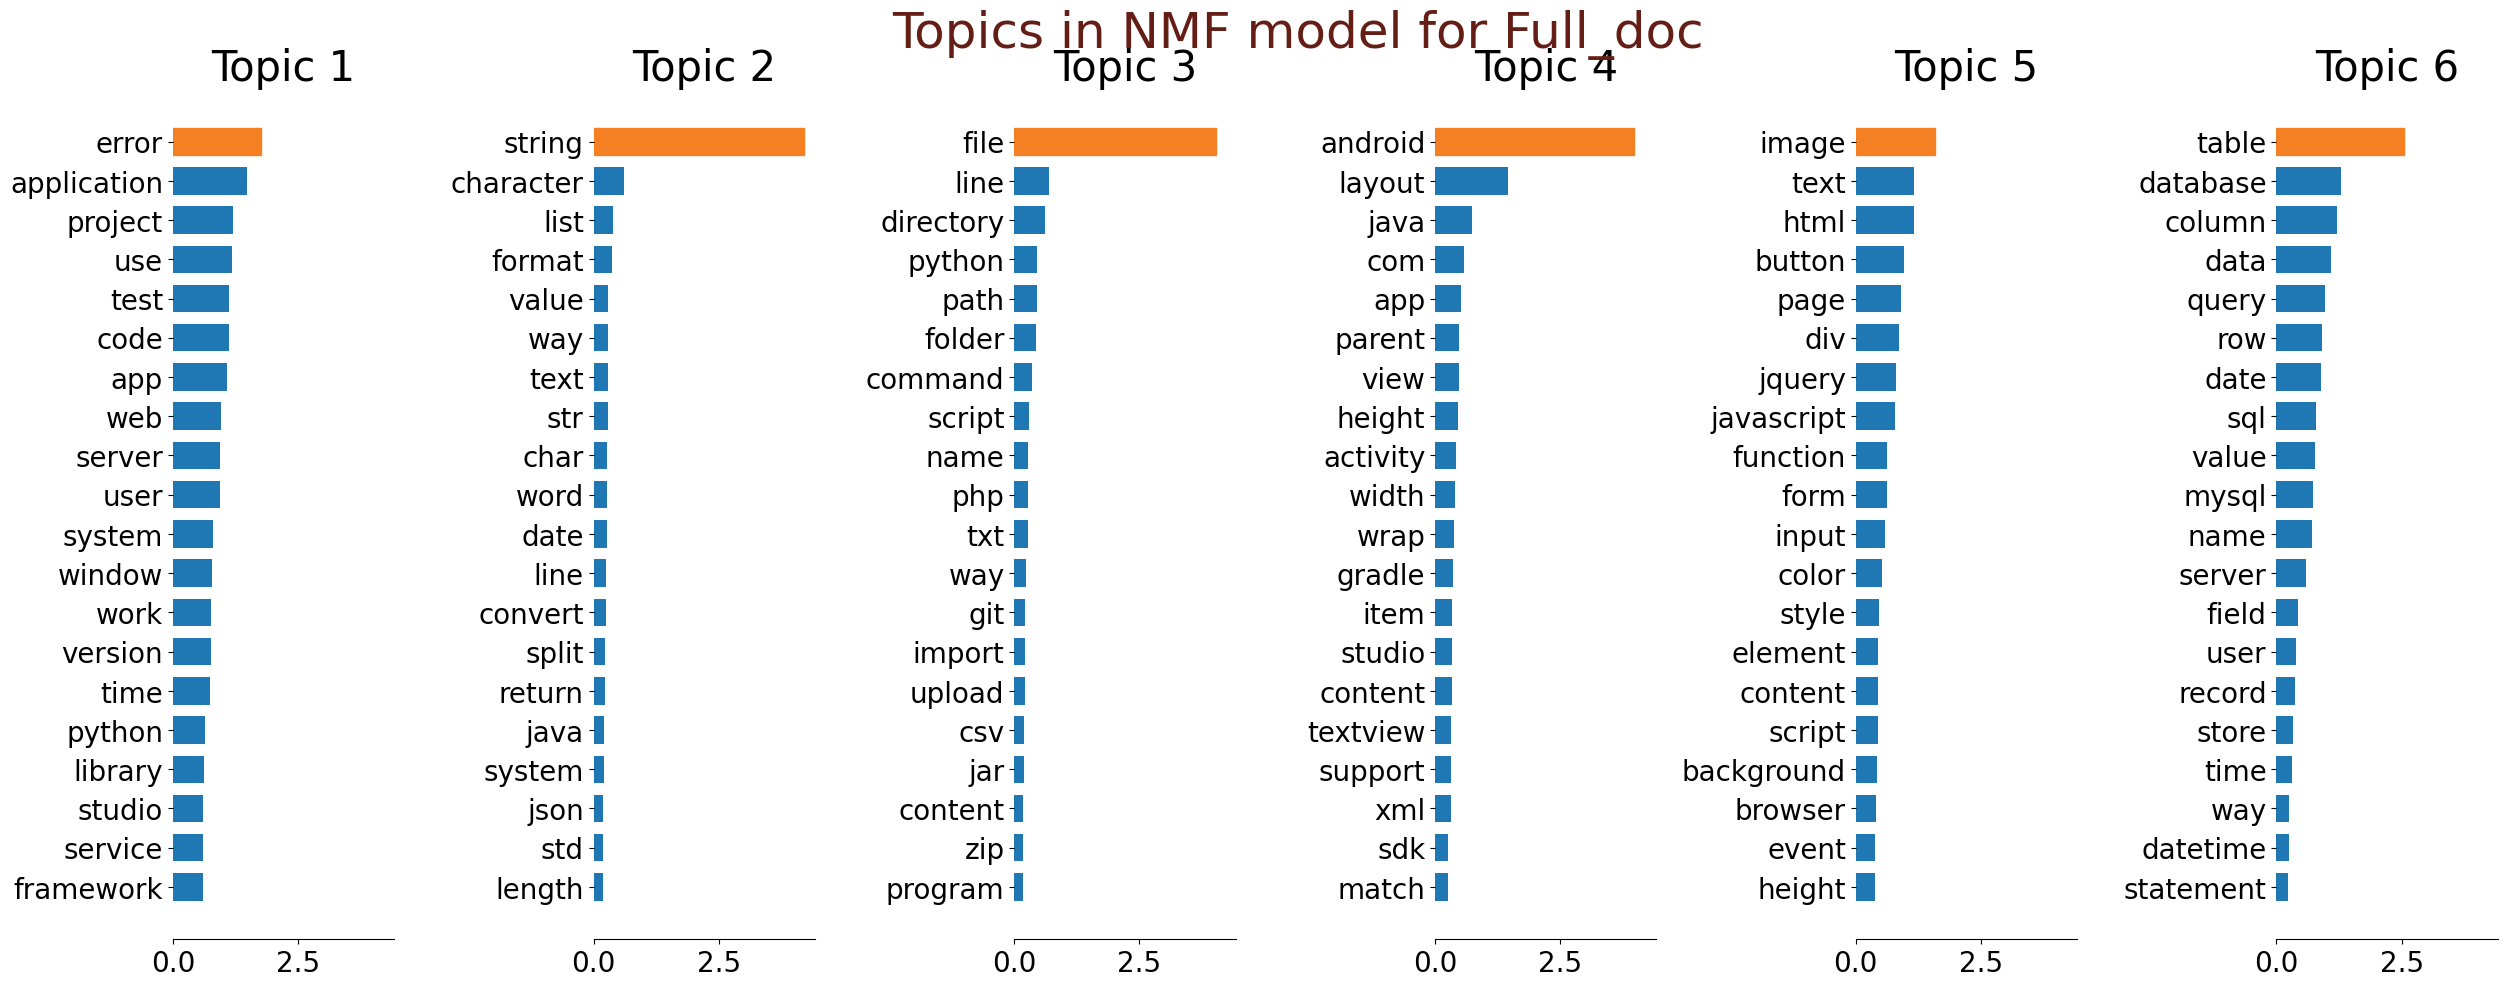

In [81]:
# Define number of topics to test
n_topics = nb_topics

print("-"*50)
print("Start NMF fitting on Full_doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf_train )

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 6 first topics
ff_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 6,
               'Topics in NMF model for Full_doc')

# Modèles supervisés

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, jaccard_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [ ]:
multilabel = joblib.load('Variables/multilabel.joblib')

In [ ]:
X_train_tfidf.head()

,aaa,ab,abc,ability,abort,abstractautowirecapablebeanfactory,abstractbeanfactory,abstraction,acc,accept,...,yml,youtube,yyyy,zend,zip,zlib,zone,zoom,zsh,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.141818,0.0,0.0,0.0


## <ins>TFIDF </ins>

### Logistic Regression (tdidf)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
%%time
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_tfidf_train, y_train)

Wall time: 1min 14s


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10], 'estimator__dual': [False],
                         'estimator__penalty': ['l1'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [ ]:
multi_logit_cv = joblib.load('Model/logit_tdidf.joblib')

In [ ]:
%%time
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_tfidf_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('jquery',), ('c++',), ('sql', 'sql-server'), (), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java', 'string'), ('c#',), ('node.js',), ('ios', 'objective-c')]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java',), ('asp.net', 'asp.net-mvc', 'c#'), ('node.js',), ('ios', 'iphone')]
Wall time: 2.32 s


In [ ]:
df_metrics_compare = metrics_score("Logit(Tdidf)",
                                   df=None,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,Logit(Tdidf)
Accuracy,0.311260
F1,0.630226
Jaccard,0.462023
Recall,0.557393
Precision,0.696595


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_Logit_tfidf.joblib", 'wb'), compress=True)

In [ ]:
joblib.dump(multi_logit_cv, open("Model/logit_tfidf.joblib", 'wb'), compress=True)

## Random forest (tdidf)

In [ ]:
%%time
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_tfidf_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Wall time: 1h 17min 55s


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [ ]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 50, 'estimator__min_samples_leaf': 5}


In [ ]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

In [ ]:
joblib.dump(rfc_best_params_ok, open("Variables/rfc_best_params_ok.joblib", 'wb'), compress=True)


In [ ]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train_tfidf, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_tfidf_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('html', 'java', 'javascript', 'jquery'), ('algorithm', 'c++', 'string'), ('database', 'sql', 'sql-server'), ('.net', 'c#'), ('css', 'html', 'javascript', 'jquery')]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery')]


In [ ]:
df_metrics_compare = metrics_score("RandomForest (Tdidf)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf)
Accuracy,0.311260,0.249866
F1,0.630226,0.630890
Jaccard,0.462023,0.495455
Recall,0.557393,0.747511
Precision,0.696595,0.587746


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_RFC_tfidf.joblib", 'wb'), compress=True)

In [ ]:
joblib.dump(rfc_final_model , open('Model/RF_final_model_tdidf.joblib', 'wb'), compress=True)

## RandomForest avec Classifier Chains (tdidf)

In [ ]:
from sklearn.multioutput import ClassifierChain

In [ ]:
%%time
rfc_base_model = RandomForestClassifier(**rfc_best_params_ok)
chain = ClassifierChain(rfc_base_model, order='random')
chain.fit(X_tfidf_train, y_train)

Wall time: 34min 46s


ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=50,
                                                      min_samples_leaf=5),
                order='random')

In [ ]:
# Predict
y_test_predicted_labels_tfidf_chain = chain.predict(X_tfidf_test)

# Inverse transform
y_test_pred_inversed_chain = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_chain)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_chain[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('html', 'javascript', 'jquery'), ('algorithm', 'c++', 'string'), ('database', 'sql', 'sql-server'), ('.net', 'c#'), ('css', 'html', 'javascript', 'jquery')]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery')]


In [ ]:
Tags_per_row_chain = y_test_predicted_labels_tfidf_chain.sum(axis=1)
null_rate_chain = round(((Tags_per_row_chain.size - np.count_nonzero(Tags_per_row_chain))
                       /Tags_per_row_chain.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for chain model")
print("-" * 50)
print("RandomForest with Classifier Chains: {}%".format(null_rate_chain))

--------------------------------------------------
Percentage of non tagged question for chain model
--------------------------------------------------
RandomForest with Classifier Chains: 3.91%


In [ ]:
df_metrics_compare = metrics_score("RFC Chains (Tdidf)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_chain)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf)
Accuracy,0.311260,0.249866,0.245487
F1,0.630226,0.630890,0.607489
Jaccard,0.462023,0.495455,0.480132
Recall,0.557393,0.747511,0.751198
Precision,0.696595,0.587746,0.570443


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_RFCC_tfidf.joblib", 'wb'), compress=True)

In [ ]:
joblib.dump(chain , open('Model/RF_chain_classifier_tdidf.joblib', 'wb'), compress=True)

# <ins> Word2vec </in>

## logistic regression (w2vec)

In [ ]:
%%time
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty":  ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_w2v = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_w2v.fit(Xw2v_train, y_train)

Wall time: 4min 59s


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100], 'estimator__dual': [False],
                         'estimator__penalty': ['l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_w2v.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_w2v.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 100, 'estimator__dual': False, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [ ]:
%%time
# Predict
y_test_predicted_labels_w2v = multi_logit_w2v.predict(Xw2v_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_w2v)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('html', 'javascript', 'jquery'), ('c++',), ('sql', 'sql-server'), (), ('html', 'javascript', 'jquery'), ('mysql', 'php'), (), (), ('node.js',), ('ios',)]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java',), ('asp.net', 'asp.net-mvc', 'c#'), ('node.js',), ('ios', 'iphone')]
Wall time: 410 ms


In [ ]:
df_metrics_compare = metrics_score("Logit (w2vec)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_w2v)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec)
Accuracy,0.311260,0.249866,0.245487,0.225380
F1,0.630226,0.630890,0.607489,0.535119
Jaccard,0.462023,0.495455,0.480132,0.346161
Recall,0.557393,0.747511,0.751198,0.401886
Precision,0.696595,0.587746,0.570443,0.682340


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_logitw2v.joblib", 'wb'), compress=True)

In [ ]:
joblib.dump(multi_logit_w2v , open('Model/logit_w2v.joblib', 'wb'), compress=True)

## Random Forest (w2vec)

In [ ]:
%%time
RF_model_w2v = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
RF_model_w2v.fit(Xw2v_train,y_train)

# Predict
y_test_predicted_labels_w2v_rfc = RF_model_w2v.predict(Xw2v_test)

Wall time: 18min 42s


In [ ]:
df_metrics_compare = metrics_score("RandomForest (w2vec)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_w2v_rfc)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec)
Accuracy,0.311260,0.249866,0.245487,0.225380,0.171582
F1,0.630226,0.630890,0.607489,0.535119,0.487870
Jaccard,0.462023,0.495455,0.480132,0.346161,0.296846
Recall,0.557393,0.747511,0.751198,0.401886,0.348470
Precision,0.696595,0.587746,0.570443,0.682340,0.675650


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_RFC_w2v.joblib", 'wb'), compress=True)

In [ ]:
joblib.dump(RF_model_w2v, open('Model/RF_model_w2v.joblib', 'wb'), compress=True)

# <ins> BERT </ins>

## Logistic regression (bert)

In [ ]:
%%time
multi_logit_bert = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear",n_jobs=-1),n_jobs=-1)
multi_logit_bert.fit(X_bert_train, y_train)

Wall time: 16min 37s


OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1, penalty='l1',
                                                 solver='liblinear'),
                    n_jobs=-1)

In [ ]:
joblib.dump(multi_logit_bert, open('Model/logit_bert.joblib', 'wb'), compress=True)

In [ ]:
%%time
# Predict
y_test_predicted_labels_bert = multi_logit_bert.predict(X_bert_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_bert)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('javascript', 'jquery'), ('c++',), ('sql', 'sql-server'), (), ('html',), ('mysql', 'php'), ('java', 'string'), ('c#',), (), ('ios', 'wpf')]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java',), ('asp.net', 'asp.net-mvc', 'c#'), ('node.js',), ('ios', 'iphone')]
Wall time: 1.17 s


In [ ]:
df_metrics_compare = metrics_score("Logit(BERT)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_bert)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT)
Accuracy,0.311260,0.249866,0.245487,0.225380,0.171582,0.251385
F1,0.630226,0.630890,0.607489,0.535119,0.487870,0.565783
Jaccard,0.462023,0.495455,0.480132,0.346161,0.296846,0.386335
Recall,0.557393,0.747511,0.751198,0.401886,0.348470,0.466891
Precision,0.696595,0.587746,0.570443,0.682340,0.675650,0.665804


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_Logit_bert.joblib", 'wb'), compress=True)

## Random Forest (bert)

In [ ]:
%%time
RF_model_bert = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
RF_model_bert.fit(X_bert_train,y_train)

joblib.dump(RF_model_bert, open('Model/RF_model_bert.joblib', 'wb'), compress=True)

# Predict
y_test_predicted_labels_bert_rfc = RF_model_bert.predict(X_bert_test)

Wall time: 40min 16s


In [ ]:
df_metrics_compare = metrics_score("RandomForest (Bert)",
                                   df= df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_bert_rfc)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert)
Accuracy,0.311260,0.249866,0.245487,0.225380,0.171582,0.251385,0.091510
F1,0.630226,0.630890,0.607489,0.535119,0.487870,0.565783,0.340924
Jaccard,0.462023,0.495455,0.480132,0.346161,0.296846,0.386335,0.162303
Recall,0.557393,0.747511,0.751198,0.401886,0.348470,0.466891,0.174525
Precision,0.696595,0.587746,0.570443,0.682340,0.675650,0.665804,0.729953


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_RFC_bert.joblib", 'wb'), compress=True)

# <ins> USE </ins>

## Logistic regression (use)

In [ ]:
%%time
multi_logit_use =OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear",n_jobs=-1),n_jobs=-1)
multi_logit_use.fit(X_use_train, y_train)

Wall time: 8min 54s


OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1, penalty='l1',
                                                 solver='liblinear'),
                    n_jobs=-1)

In [ ]:
#paramètre C=100, penalty="l2", dual=False, solver="liblinear"
joblib.dump(multi_logit_use, open('Model/logit_use.joblib', 'wb'), compress=True)

In [ ]:
%%time
# Predict
y_test_predicted_labels_use= multi_logit_use.predict(X_use_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_use)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('javascript', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java', 'string'), ('c#',), (), ('ios', 'objective-c')]
True: [('html', 'java', 'jquery'), ('c++',), ('sql', 'sql-server'), ('c#',), ('css', 'html', 'javascript', 'jquery'), ('mysql', 'php'), ('java',), ('asp.net', 'asp.net-mvc', 'c#'), ('node.js',), ('ios', 'iphone')]
Wall time: 1.03 s


In [ ]:
df_metrics_compare = metrics_score("Logit (Use)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_use)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert),Logit (Use)
Accuracy,0.311260,0.249866,0.245487,0.225380,0.171582,0.251385,0.091510,0.338427
F1,0.630226,0.630890,0.607489,0.535119,0.487870,0.565783,0.340924,0.660736
Jaccard,0.462023,0.495455,0.480132,0.346161,0.296846,0.386335,0.162303,0.483994
Recall,0.557393,0.747511,0.751198,0.401886,0.348470,0.466891,0.174525,0.577359
Precision,0.696595,0.587746,0.570443,0.682340,0.675650,0.665804,0.729953,0.720808


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_logit_use.joblib", 'wb'), compress=True)

## Random Forest (use)

In [ ]:
%%time
RF_model_use = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok), n_jobs=4)
RF_model_use.fit(X_use_train ,y_train)

joblib.dump(RF_model_use, open('Model/RF_model_use.joblib', 'wb'), compress=True)

# Predict
y_test_predicted_labels_use_rfc = RF_model_use.predict(X_use_test)

Wall time: 31min 56s


In [ ]:
df_metrics_compare = metrics_score("RandomForest (Use)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_use_rfc)
df_metrics_compare

,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert),Logit (Use),RandomForest (Use)
Accuracy,0.311260,0.249866,0.245487,0.225380,0.171582,0.251385,0.091510,0.338427,0.296068
F1,0.630226,0.630890,0.607489,0.535119,0.487870,0.565783,0.340924,0.660736,0.637790
Jaccard,0.462023,0.495455,0.480132,0.346161,0.296846,0.386335,0.162303,0.483994,0.449970
Recall,0.557393,0.747511,0.751198,0.401886,0.348470,0.466891,0.174525,0.577359,0.538113
Precision,0.696595,0.587746,0.570443,0.682340,0.675650,0.665804,0.729953,0.720808,0.717817


In [ ]:
joblib.dump(df_metrics_compare, open("Variables/df_metrics_compare_final_Table.joblib", 'wb'), compress=True)

# Modélisation PCA

## Tfidf

In [ ]:
%%time
logit_tfidf_pca = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1",dual=False, solver="liblinear", n_jobs=-1), n_jobs=-1)

logit_tfidf_pca.fit(X_tfidf_train_pca, y_train)

In [ ]:
%%time
#predict
y_test_predicted_labels_tfidf_pca = logit_tfidf_pca.predict(X_tfidf_test_pca)

In [ ]:
joblib.dump(logit_tfidf_pca, open('Model/logit_tfidf_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca = metrics_score("logit pca (tfidf)",
                                   df=None,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_use_rfc)
df_metrics_compare_pca

In [ ]:
#RandomForestClassifier best_params with full dataset
rfc_final_model_tfidf_pca = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok), n_jobs=-1)
rfc_final_model_tfidf_pca.fit(X_train_tfidf_pca, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc_pca = rfc_final_model_tfidf_pca.predict(X_tfidf_test_pca)

In [ ]:
joblib.dump(rfc_final_model_tfidf_pca, open('Model/rfc_final_model_tfidf_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca = metrics_score("RF pca (tfidf)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_use_rfc)
df_metrics_compare_pca

## W2vec

In [ ]:
%%time
logit_w2vec_pca = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1",dual=False, solver="liblinear"), n_jobs=4)
logit_w2vec_pca.fit(X_train_w2v_pca, y_train)
#predict
y_test_predicted_labels_tfidf_pca = logit_w2vec_pca.predict(X_test_w2v_pca)

CPU times: user 663 ms, sys: 214 ms, total: 877 ms
Wall time: 26.6 s


In [ ]:
#joblib.dump(logit_w2vec_pca, open('Model/logit_w2vec_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca = metrics_score("logit pca (w2vec)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred =y_test_predicted_labels_tfidf_pca)
df_metrics_compare_pca

,logit pca (w2vec)
Accuracy,0.176676
F1,0.476678
Jaccard,0.284778
Recall,0.329031
Precision,0.645042


In [ ]:
rfc_best_params_ok={'class_weight':'balanced', 'max_depth':50, 'min_samples_leaf':5}

In [ ]:
%%time
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model_w2vec_pca = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model_w2vec_pca.fit(X_train_w2v_pca, y_train)


In [ ]:
# Predict
y_test_predicted_labels_w2vec_rfc_pca = rfc_final_model_w2vec_pca.predict(X_test_w2v_pca)

In [ ]:
#joblib.dump(rfc_final_model_w2vec_pca, open('Model/rfc_final_model_w2vec_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca = metrics_score("RF pca (w2vec)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_w2vec_rfc_pca)
df_metrics_compare_pca

,logit pca (w2vec),RF pca (w2vec)
Accuracy,0.176676,0.178552
F1,0.476678,0.490961
Jaccard,0.284778,0.300663
Recall,0.329031,0.351104
Precision,0.645042,0.681156


# Bert

In [ ]:
%%time
logit_bert_pca = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear"),n_jobs=4)
logit_bert_pca.fit(X_train_bert_pca, y_train)


CPU times: user 497 ms, sys: 62 ms, total: 559 ms
Wall time: 28.1 s


OneVsRestClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                 solver='liblinear'),
                    n_jobs=4)

In [ ]:
#predict
y_test_predicted_labels_bert_pca = logit_bert_pca.predict(X_test_bert_pca)

In [ ]:
joblib.dump(logit_bert_pca, open('Model/logit_bert_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca = metrics_score("logit pca (bert)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_bert_pca)
df_metrics_compare_pca

,logit pca (w2vec),RF pca (w2vec),logit pca (bert)
Accuracy,0.176676,0.178552,0.131725
F1,0.476678,0.490961,0.409977
Jaccard,0.284778,0.300663,0.217888
Recall,0.329031,0.351104,0.244482
Precision,0.645042,0.681156,0.638108


In [ ]:
%%time
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model_bert_pca = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model_bert_pca.fit(X_train_bert_pca, y_train)

CPU times: user 18min 44s, sys: 1.2 s, total: 18min 46s
Wall time: 18min 49s


OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=50,
                                                     min_samples_leaf=5))

In [ ]:
# Predict
y_test_predicted_labels_bert_rfc_pca = rfc_final_model_bert_pca.predict(X_test_bert_pca)

In [ ]:
df_metrics_compare_pca = metrics_score("RF pca (bert)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_bert_rfc_pca)
df_metrics_compare_pca

,logit pca (w2vec),RF pca (w2vec),logit pca (bert),RF pca (bert)
Accuracy,0.176676,0.178552,0.131725,0.233959
F1,0.476678,0.490961,0.409977,0.561367
Jaccard,0.284778,0.300663,0.217888,0.354801
Recall,0.329031,0.351104,0.244482,0.397777
Precision,0.645042,0.681156,0.638108,0.752749


In [ ]:
joblib.dump(rfc_final_model_bert_pca, open('Model/rfc_final_model_bert_pca.joblib', 'wb'), compress=True)

# USE

In [ ]:
%%time
logit_use_pca = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear"),n_jobs=-1)
logit_use_pca.fit(X_train_use_pca, y_train)

CPU times: user 1.01 s, sys: 216 ms, total: 1.22 s
Wall time: 1min 27s


OneVsRestClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                 solver='liblinear'),
                    n_jobs=-1)

In [ ]:
#predict
y_test_predicted_labels_use_pca = logit_use_pca .predict(X_test_use_pca)

In [ ]:
joblib.dump(logit_use_pca, open('Model/logit_use_pca.joblib', 'wb'), compress=True)

In [ ]:
df_metrics_compare_pca=None

In [ ]:
df_metrics_compare_pca = metrics_score("logit pca (use)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_use_pca)
df_metrics_compare_pca

,logit pca (w2vec),RF pca (w2vec),logit pca (bert),RF pca (bert),logit pca (use)
Accuracy,0.176676,0.178552,0.131725,0.233959,0.328329
F1,0.476678,0.490961,0.409977,0.561367,0.654269
Jaccard,0.284778,0.300663,0.217888,0.354801,0.473059
Recall,0.329031,0.351104,0.244482,0.397777,0.554180
Precision,0.645042,0.681156,0.638108,0.752749,0.734989


In [ ]:
%%time
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model_bert_pca = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok), n_jobs=-1)
rfc_final_model_bert_pca.fit(X_train_use_pca, y_train)

CPU times: user 7.63 s, sys: 1.46 s, total: 9.09 s
Wall time: 19min 47s


OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=50,
                                                     min_samples_leaf=5),
                    n_jobs=-1)

In [ ]:
# Predict
y_test_predicted_labels_bert_rfc_pca = rfc_final_model_bert_pca.predict(X_test_use_pca)

In [ ]:
df_metrics_compare_pca = metrics_score("RF pca (use)",
                                   df=df_metrics_compare_pca,
                                   y_true = y_test,
                                   y_pred =y_test_predicted_labels_bert_rfc_pca )
df_metrics_compare_pca

,logit pca (w2vec),RF pca (w2vec),logit pca (bert),RF pca (bert),logit pca (use),RF pca (use)
Accuracy,0.176676,0.178552,0.131725,0.233959,0.328329,0.233959
F1,0.476678,0.490961,0.409977,0.561367,0.654269,0.561367
Jaccard,0.284778,0.300663,0.217888,0.354801,0.473059,0.354801
Recall,0.329031,0.351104,0.244482,0.397777,0.554180,0.397777
Precision,0.645042,0.681156,0.638108,0.752749,0.734989,0.752749


In [ ]:
#joblib.dump(df_metrics_compare_pca, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/table_metrics_score_final_pca.joblib', 'wb'), compress=True)

In [ ]:
joblib.dump(rfc_final_model_bert_pca, open('Model/rfc_final_model_bert_pca.joblib', 'wb'), compress=True)